#**Home Credit - Credit Risk Analysis**

# Data Gathering

In [ ]:
!java -version

openjdk version "11.0.25" 2024-10-15
OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("HomeCreditDataProcessing").getOrCreate()

print(spark.version)

3.5.4


In [ ]:
import os
import io
import requests
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.impute import KNNImputer

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, rand, expr, isnan, when, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [ ]:
  url = "https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/home-credit-indonesia/home-credit-default-risk.zip"
  output_folder = "/content/output_zip"

  def download_and_extract_zip(url, output_folder):
      try:
          print("Mengunduh file ZIP...")
          response = requests.get(url)
          response.raise_for_status()
          if not os.path.exists(output_folder):
              os.makedirs(output_folder)
          print("Mengekstrak file ZIP...")
          with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
              zip_ref.extractall(output_folder)
          print(f"File berhasil diekstrak ke folder: {output_folder}")

      except requests.exceptions.RequestException as e:
          print(f"Error saat mengunduh file: {e}")
      except zipfile.BadZipFile:
          print("File ZIP tidak valid.")

  download_and_extract_zip(url, output_folder)
  print("Isi folder output:")
  for root, dirs, files in os.walk(output_folder):
      for file in files:
          print(os.path.join(root, file))


Mengunduh file ZIP...
Mengekstrak file ZIP...
File berhasil diekstrak ke folder: /content/output_zip
Isi folder output:
/content/output_zip/HomeCredit_columns_description.csv
/content/output_zip/bureau.csv
/content/output_zip/bureau_balance.csv
/content/output_zip/sample_submission.csv
/content/output_zip/credit_card_balance.csv
/content/output_zip/POS_CASH_balance.csv
/content/output_zip/application_train.csv
/content/output_zip/installments_payments.csv
/content/output_zip/application_test.csv
/content/output_zip/previous_application.csv


In [ ]:
df1 = spark.read.csv("/content/output_zip/application_train.csv", header=True, inferSchema=True)
df2 = spark.read.csv("/content/output_zip/application_test.csv", header=True, inferSchema=True)
df3 = spark.read.csv("/content/output_zip/bureau_balance.csv", header=True, inferSchema=True)
df4 = spark.read.csv("/content/output_zip/bureau.csv", header=True, inferSchema=True)
df5 = spark.read.csv("/content/output_zip/previous_application.csv", header=True, inferSchema=True)
df6 = spark.read.csv("/content/output_zip/credit_card_balance.csv", header=True, inferSchema=True)
df7 = spark.read.csv("/content/output_zip/installments_payments.csv", header=True, inferSchema=True)
df8 = spark.read.csv("/content/output_zip/POS_CASH_balance.csv", header=True, inferSchema=True)

# Data Understanding & Cleaning


In [ ]:
df1.printSchema()
df1.summary().show()
df2.printSchema()
df2.summary().show()
df3.printSchema()
df3.summary().show()
df4.printSchema()
df4.summary().show()
df5.printSchema()
df5.summary().show()
df6.printSchema()
df6.summary().show()
df7.printSchema()
df7.summary().show()
df8.printSchema()
df8.summary().show()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [ ]:
df1.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df1.columns]).show()
df2.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df2.columns]).show()
df3.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df3.columns]).show()
df4.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df4.columns]).show()
df5.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df5.columns]).show()
df6.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df6.columns]).show()
df7.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df7.columns]).show()
df8.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df8.columns]).show()


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+----

In [ ]:
print("Jumlah duplikasi: ", (df1.count() - df1.distinct().count()))
print("Jumlah duplikasi: ", (df2.count() - df2.distinct().count()))
print("Jumlah duplikasi: ", (df3.count() - df3.distinct().count()))
print("Jumlah duplikasi: ", (df4.count() - df4.distinct().count()))
print("Jumlah duplikasi: ", (df5.count() - df5.distinct().count()))
print("Jumlah duplikasi: ", (df6.count() - df6.distinct().count()))
print("Jumlah duplikasi: ", (df7.count() - df7.distinct().count()))
print("Jumlah duplikasi: ", (df8.count() - df8.distinct().count()))

Jumlah duplikasi:  0
Jumlah duplikasi:  0
Jumlah duplikasi:  0
Jumlah duplikasi:  0
Jumlah duplikasi:  0
Jumlah duplikasi:  0
Jumlah duplikasi:  0
Jumlah duplikasi:  0


In [ ]:
def calculate_missing_percentage(df):
    total_rows = df.count()
    missing_percentage = {}
    for col_name in df.columns:
        missing_count = df.filter(col(col_name).isNull() | isnan(col(col_name))).count()
        missing_percentage[col_name] = (missing_count / total_rows) * 100
    return missing_percentage
def drop_columns_with_high_missing(df, missing_percentage):
    columns_to_drop = [col_name for col_name, percentage in missing_percentage.items() if percentage > 30]
    return df.drop(*columns_to_drop)
def impute_missing_values(df):
    numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double']]
    categorical_cols = [col_name for col_name, dtype in df.dtypes if dtype == 'string']
    for col_name in numeric_cols:
        median_value = df.approxQuantile(col_name, [0.5], 0.01)[0]  # Hitung median
        df = df.withColumn(col_name, when(col(col_name).isNull(), median_value).otherwise(col(col_name)))
    for col_name in categorical_cols:
        mode_value = df.groupBy(col_name).count().orderBy("count", ascending=False).first()[0]  # Hitung modus
        df = df.withColumn(col_name, when(col(col_name).isNull(), mode_value).otherwise(col(col_name)))

    return df

dataframes = [df1, df2, df3, df4, df5, df6, df7, df8]
for i, df in enumerate(dataframes):
    print(f"Memproses DataFrame {i+1}...")
    missing_percentage = calculate_missing_percentage(df)
    df = drop_columns_with_high_missing(df, missing_percentage)
    df = impute_missing_values(df)

    dataframes[i] = df

for i, df in enumerate(dataframes, start=1):
    print(f"DataFrame {i} setelah data cleaning:")
    df.show(5)
df1, df2, df3, df4, df5, df6, df7, df8 = dataframes

Memproses DataFrame 1...
Memproses DataFrame 2...
Memproses DataFrame 3...
Memproses DataFrame 4...
Memproses DataFrame 5...
Memproses DataFrame 6...
Memproses DataFrame 7...
Memproses DataFrame 8...
DataFrame 1 setelah data cleaning:
+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+------------------+-------------------+------------------------+----

In [ ]:
datasets = {
    "df1": df1, "df2": df2, "df3": df3, "df4": df4,
    "df5": df5, "df6": df6, "df7": df7, "df8": df8
}

id_columns = ["SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"]
for name, df in datasets.items():
    for id_col in id_columns:
        if id_col in df.columns:
            df = df.withColumn(id_col, col(id_col).cast("string"))
    datasets[name] = df

df1, df2, df3, df4, df5, df6, df7, df8 = datasets.values()
df1.printSchema()
df2.printSchema()
df3.printSchema()
df4.printSchema()
df5.printSchema()
df6.printSchema()
df7.printSchema()
df8.printSchema()

root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: double (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: double (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: double (nullable = true)
 |-- DAYS_EMPLOYED: double (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: double (nullable = true)
 |-- FLAG_MOBIL: doub

In [ ]:
df1.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df1.columns]).show()
df2.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df2.columns]).show()
df3.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df3.columns]).show()
df4.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df4.columns]).show()
df5.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df5.columns]).show()
df6.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df6.columns]).show()
df7.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df7.columns]).show()
df8.select([(count(when(col(c).isNull() | isnan(col(c)), c))).alias(c) for c in df8.columns]).show()


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+---------------

In [ ]:
columns_to_drop = ["FLAG_MOBIL","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_PHONE"
    "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21",
    "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_QRT","WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START","NAME_TYPE_SUITE"
]

df1_cleaned = df1.drop(*columns_to_drop)
df2_cleaned = df2.drop(*columns_to_drop)
print("Schema df1 setelah penghapusan:")
df1_cleaned.printSchema()
print("Schema df2 setelah penghapusan:")
df2_cleaned.printSchema()


Schema df1 setelah penghapusan:
root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: double (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: double (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: double (nullable = true)
 |-- DAYS_EMPLOYED: double (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: double (nullable = true)
 |-- FLAG_CONT_MOBILE: double (nulla

In [ ]:
df1_cleaned.printSchema()

root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: double (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: double (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: double (nullable = true)
 |-- DAYS_EMPLOYED: double (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: double (nullable = true)
 |-- FLAG_CONT_MOBILE: double (nullable = true)
 |-- FLAG_PHONE: dou

In [ ]:
df1_cleaned = df1_cleaned.withColumn("AGE_YEARS", (col("DAYS_BIRTH") / -365).cast("double"))
df2_cleaned = df2_cleaned.withColumn("AGE_YEARS", (col("DAYS_BIRTH") / -365).cast("double"))

In [ ]:
print("Schema df1 setelah penghapusan:")
df1_cleaned.printSchema()

print("Schema df2 setelah penghapusan:")
df2_cleaned.printSchema()

Schema df1 setelah penghapusan:
root
 |-- SK_ID_CURR: string (nullable = true)
 |-- TARGET: double (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: double (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: double (nullable = true)
 |-- DAYS_EMPLOYED: double (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: double (nullable = true)
 |-- FLAG_CONT_MOBILE: double (nulla

# Exploratory Data Analysis

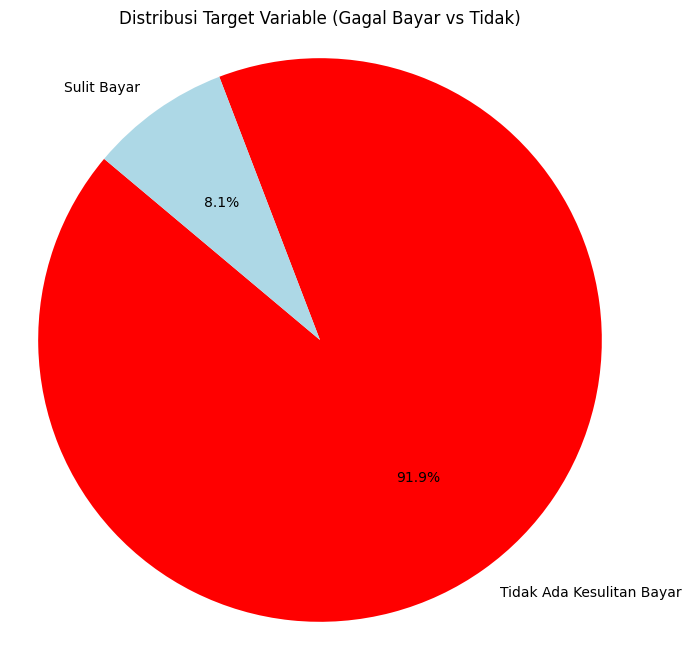

In [ ]:
target_dist = df1.groupBy("TARGET").count().toPandas()
labels = ["Tidak Ada Kesulitan Bayar", "Sulit Bayar"]
colors = ["red", "lightblue"]
plt.figure(figsize=(8, 8))
plt.pie(target_dist['count'], labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribusi Target Variable (Gagal Bayar vs Tidak)")
plt.axis('equal')
plt.show()


<ipython-input-18-107182557607>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="TARGET", y="count", data=target_dist, palette="viridis")


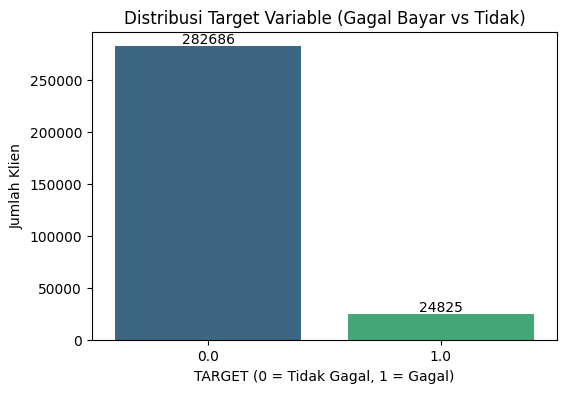

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target_dist = df1_cleaned.groupBy("TARGET").count().toPandas()
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="TARGET", y="count", data=target_dist, palette="viridis")
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points"
    )

plt.title("Distribusi Target Variable (Gagal Bayar vs Tidak)")
plt.xlabel("TARGET (0 = Tidak Gagal, 1 = Gagal)")
plt.ylabel("Jumlah Klien")
plt.show()

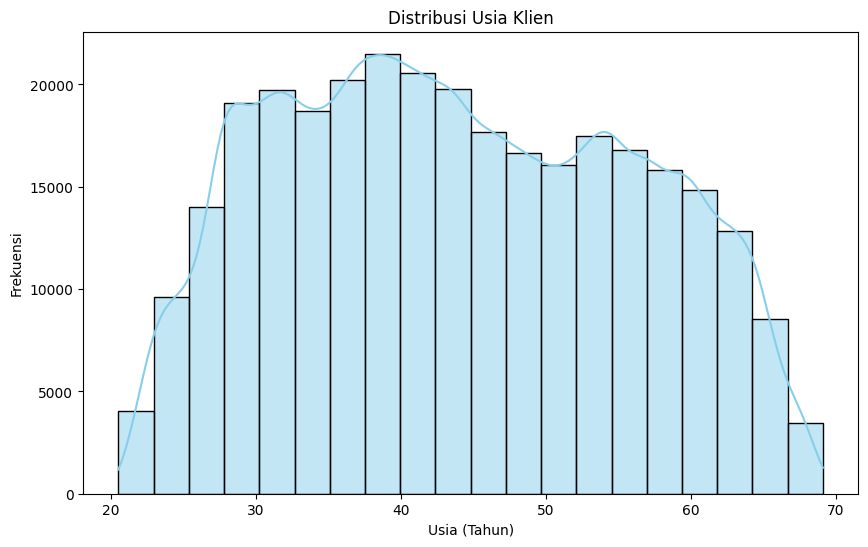

In [ ]:
age_pd = df1_cleaned.select("AGE_YEARS").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(age_pd["AGE_YEARS"], bins=20, kde=True, color="skyblue")
plt.title("Distribusi Usia Klien")
plt.xlabel("Usia (Tahun)")
plt.ylabel("Frekuensi")
plt.show()

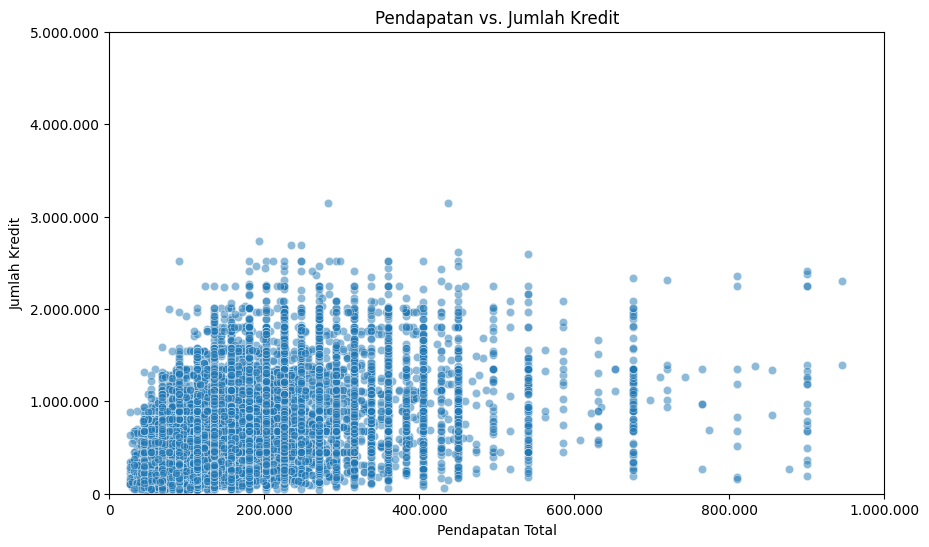

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

sample_df = df1_cleaned.sample(0.1).select("AMT_INCOME_TOTAL", "AMT_CREDIT").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="AMT_INCOME_TOTAL", y="AMT_CREDIT", data=sample_df, alpha=0.5)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))
plt.title("Pendapatan vs. Jumlah Kredit")
plt.xlabel("Pendapatan Total")
plt.ylabel("Jumlah Kredit")
plt.xlim(0, 1e6)  # Batasi outlier di sumbu X
plt.ylim(0, 5e6)  # Batasi jumlah kredit sampai 5 juta (5e6)
plt.show()


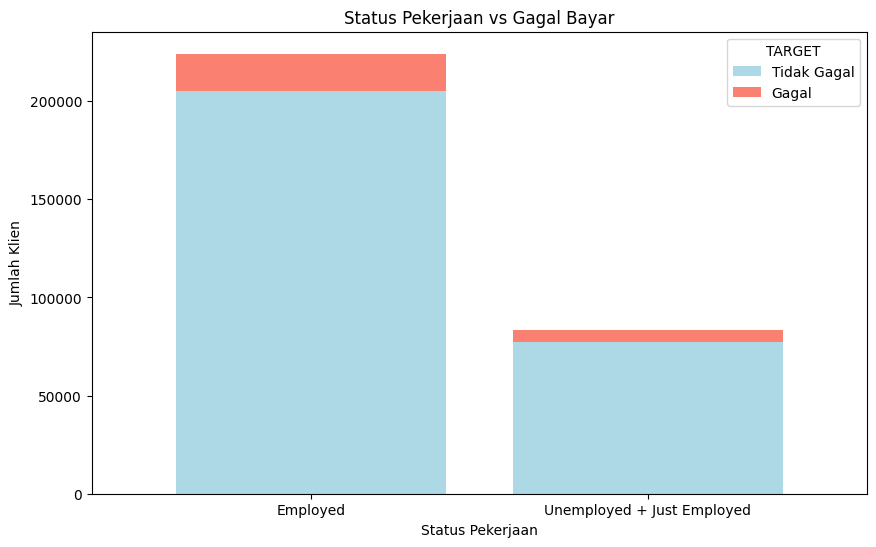

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, when

anomaly_pd = df1_cleaned.withColumn(
    "EMPLOYMENT_STATUS",
    when((col("DAYS_EMPLOYED") == 365243) | (col("DAYS_EMPLOYED") >= -365), "Unemployed + Just Employed")
    .otherwise("Employed")
).groupBy("EMPLOYMENT_STATUS", "TARGET").count().toPandas()
anomaly_pivot = anomaly_pd.pivot_table(index='EMPLOYMENT_STATUS', columns='TARGET', values='count', aggfunc='sum', fill_value=0)
ax = anomaly_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'salmon'], width=0.8)
plt.title("Status Pekerjaan vs Gagal Bayar")
plt.xlabel("Status Pekerjaan")
plt.ylabel("Jumlah Klien")
plt.xticks(rotation=0)
plt.legend(title="TARGET", labels=["Tidak Gagal", "Gagal"])
plt.show()


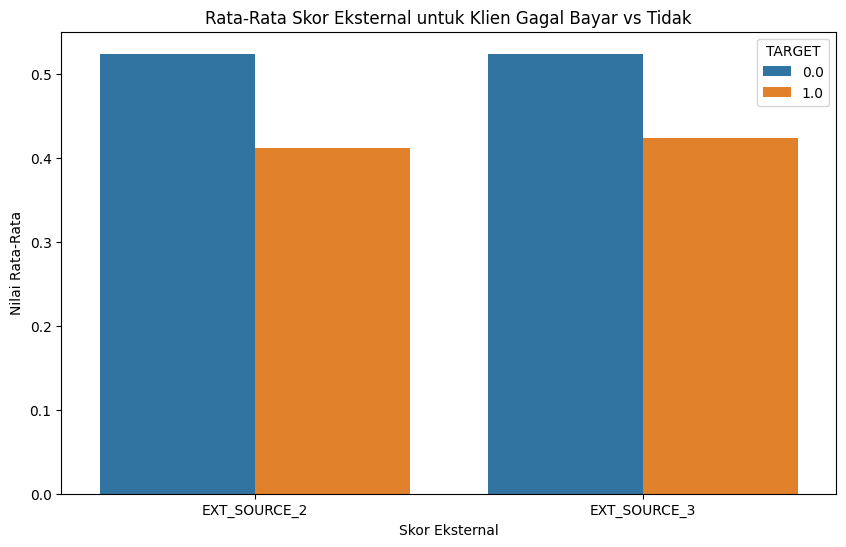

In [ ]:
ext_source_pd = df1.groupBy("TARGET").agg(
    F.mean("EXT_SOURCE_2").alias("EXT_SOURCE_2"),
    F.mean("EXT_SOURCE_3").alias("EXT_SOURCE_3")
).toPandas()
ext_source_pd_melted = ext_source_pd.melt(id_vars="TARGET", value_vars=["EXT_SOURCE_2", "EXT_SOURCE_3"], var_name="EXT_SOURCE", value_name="Mean_Score")
plt.figure(figsize=(10, 6))
sns.barplot(data=ext_source_pd_melted, x="EXT_SOURCE", y="Mean_Score", hue="TARGET")
plt.title("Rata-Rata Skor Eksternal untuk Klien Gagal Bayar vs Tidak")
plt.xlabel("Skor Eksternal")
plt.ylabel("Nilai Rata-Rata")
plt.show()


<ipython-input-23-b4d5dc8749b5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="default_rate", y="ORGANIZATION_TYPE", data=occupation_risk, palette="rocket")


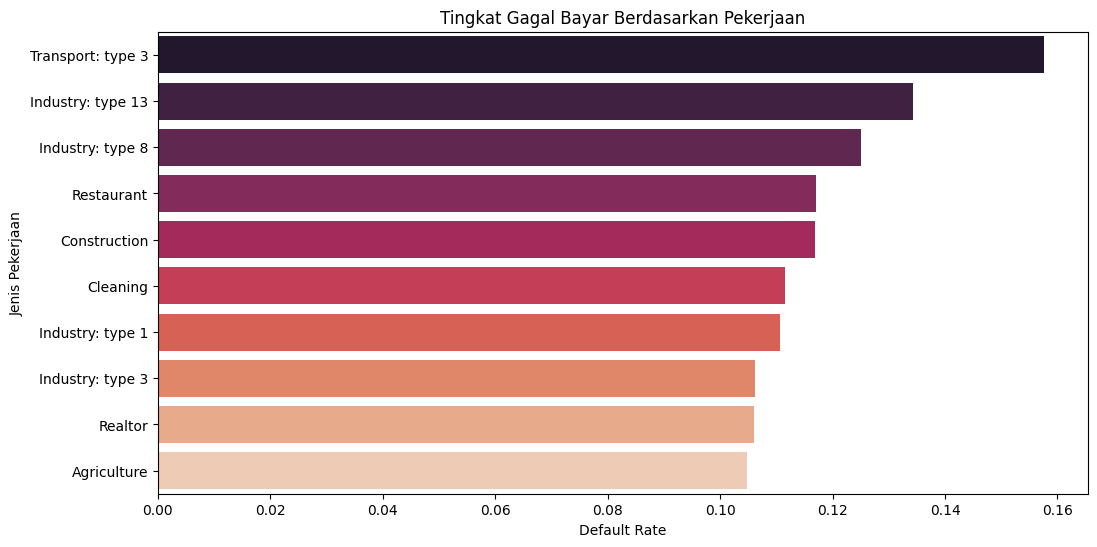

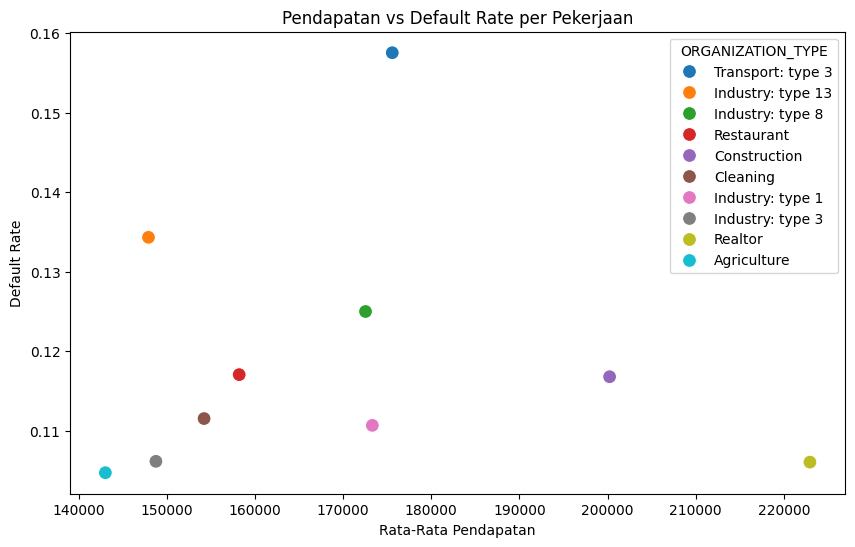

In [ ]:
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

occupation_risk = df1_cleaned.groupBy("ORGANIZATION_TYPE").agg(
    mean("TARGET").alias("default_rate"),
    mean("AMT_INCOME_TOTAL").alias("avg_income")
).orderBy("default_rate", ascending=False).limit(10).toPandas()  # Menampilkan hanya 10 item teratas

plt.figure(figsize=(12, 6))
sns.barplot(x="default_rate", y="ORGANIZATION_TYPE", data=occupation_risk, palette="rocket")
plt.title("Tingkat Gagal Bayar Berdasarkan Pekerjaan")
plt.xlabel("Default Rate")
plt.ylabel("Jenis Pekerjaan")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="avg_income", y="default_rate", data=occupation_risk, hue="ORGANIZATION_TYPE", s=100)
plt.title("Pendapatan vs Default Rate per Pekerjaan")
plt.xlabel("Rata-Rata Pendapatan")
plt.ylabel("Default Rate")
plt.show()


<ipython-input-24-98d13d893d97>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="CODE_GENDER", y="default_rate", data=gender_analysis, palette="viridis")


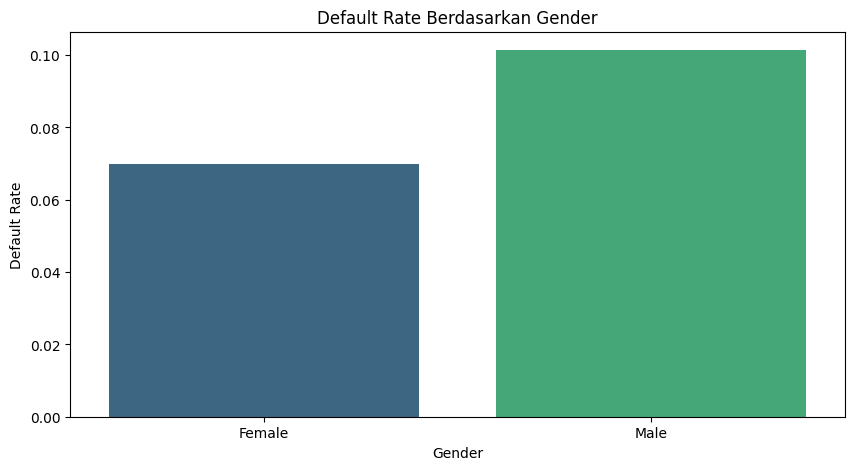

In [ ]:
gender_analysis = df1_cleaned.groupBy("CODE_GENDER").agg(
    count("*").alias("total_clients"),
    mean("TARGET").alias("default_rate"),
    mean("AMT_CREDIT").alias("avg_credit")
).toPandas()
gender_analysis['CODE_GENDER'] = gender_analysis['CODE_GENDER'].replace({'M': 'Male', 'F': 'Female'})
gender_analysis = gender_analysis[gender_analysis['CODE_GENDER'].isin(['Male', 'Female'])]

plt.figure(figsize=(10, 5))
sns.barplot(x="CODE_GENDER", y="default_rate", data=gender_analysis, palette="viridis")
plt.title("Default Rate Berdasarkan Gender")
plt.xlabel("Gender")
plt.ylabel("Default Rate")
plt.show()

<ipython-input-25-0ada13e685a6>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="REGION_RATING_CLIENT", y="total_loans", data=region_loan_count, palette="Blues_d", ax=ax1, label="Total Pinjaman")


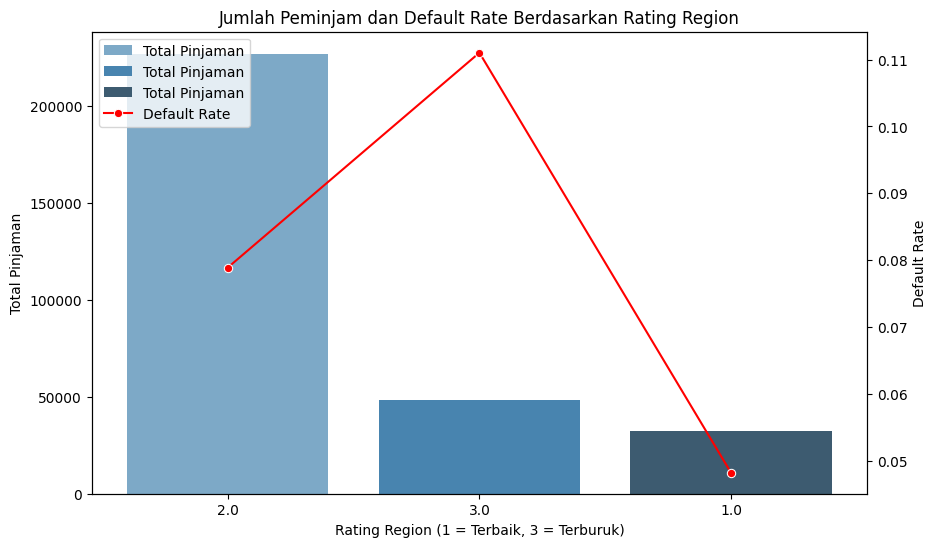

In [ ]:
region_loan_count = df1_cleaned.groupby("REGION_RATING_CLIENT").agg(
    count("*").alias("total_loans"),
    mean("TARGET").alias("default_rate")
).orderBy("total_loans", ascending=False).toPandas()

region_loan_count['REGION_RATING_CLIENT'] = region_loan_count['REGION_RATING_CLIENT'].astype(str)
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x="REGION_RATING_CLIENT", y="total_loans", data=region_loan_count, palette="Blues_d", ax=ax1, label="Total Pinjaman")
ax1.set_xlabel("Rating Region (1 = Terbaik, 3 = Terburuk)")
ax1.set_ylabel("Total Pinjaman")
ax2 = ax1.twinx()
sns.lineplot(x="REGION_RATING_CLIENT", y="default_rate", data=region_loan_count, color="red", marker="o", ax=ax2, label="Default Rate")
ax2.set_ylabel("Default Rate")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

plt.title("Jumlah Peminjam dan Default Rate Berdasarkan Rating Region")
plt.show()

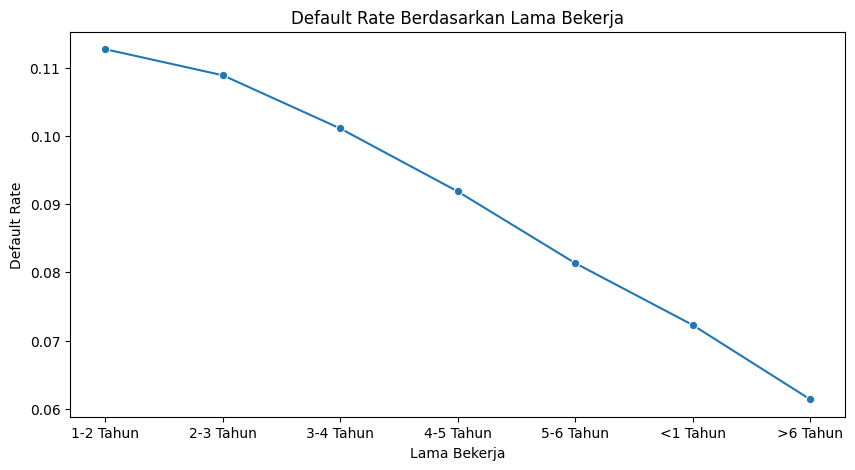

In [ ]:
from pyspark.sql.functions import mean, when, round, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df1 = df1.withColumn("EMPLOYED_YEARS",
    when(col("DAYS_EMPLOYED") == 365243, 0)
    .otherwise(round(-col("DAYS_EMPLOYED") / 365, 1))
)

employed_risk = df1.withColumn("employment_group",
    when(col("EMPLOYED_YEARS") < 1, "<1 Tahun")
    .when((col("EMPLOYED_YEARS") >= 1) & (col("EMPLOYED_YEARS") < 2), "1-2 Tahun")
    .when((col("EMPLOYED_YEARS") >= 2) & (col("EMPLOYED_YEARS") < 3), "2-3 Tahun")
    .when((col("EMPLOYED_YEARS") >= 3) & (col("EMPLOYED_YEARS") < 4), "3-4 Tahun")
    .when((col("EMPLOYED_YEARS") >= 4) & (col("EMPLOYED_YEARS") < 5), "4-5 Tahun")
    .when((col("EMPLOYED_YEARS") >= 5) & (col("EMPLOYED_YEARS") < 6), "5-6 Tahun")
    .otherwise(">6 Tahun")
).groupBy("employment_group").agg(
    mean("TARGET").alias("default_rate")
).orderBy("employment_group").toPandas()  # Urutkan berdasarkan employment_group
plt.figure(figsize=(10, 5))
sns.lineplot(x="employment_group", y="default_rate", data=employed_risk, marker="o")
plt.title("Default Rate Berdasarkan Lama Bekerja")
plt.xlabel("Lama Bekerja")
plt.ylabel("Default Rate")
plt.show()


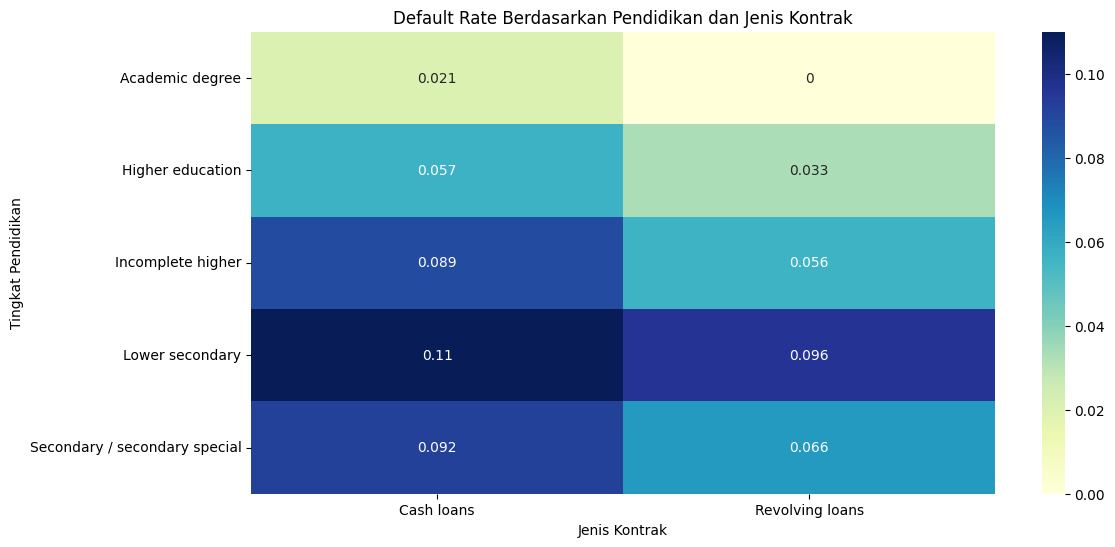

In [ ]:
edu_contract_risk = df1.groupBy("NAME_EDUCATION_TYPE", "NAME_CONTRACT_TYPE").agg(
    F.mean("TARGET").alias("default_rate")
)
edu_contract_risk_pd = edu_contract_risk.toPandas()
pivoted = edu_contract_risk_pd.pivot(index="NAME_EDUCATION_TYPE", columns="NAME_CONTRACT_TYPE", values="default_rate")
plt.figure(figsize=(12, 6))
sns.heatmap(pivoted, annot=True, cmap="YlGnBu")
plt.title("Default Rate Berdasarkan Pendidikan dan Jenis Kontrak")
plt.xlabel("Jenis Kontrak")
plt.ylabel("Tingkat Pendidikan")
plt.show()


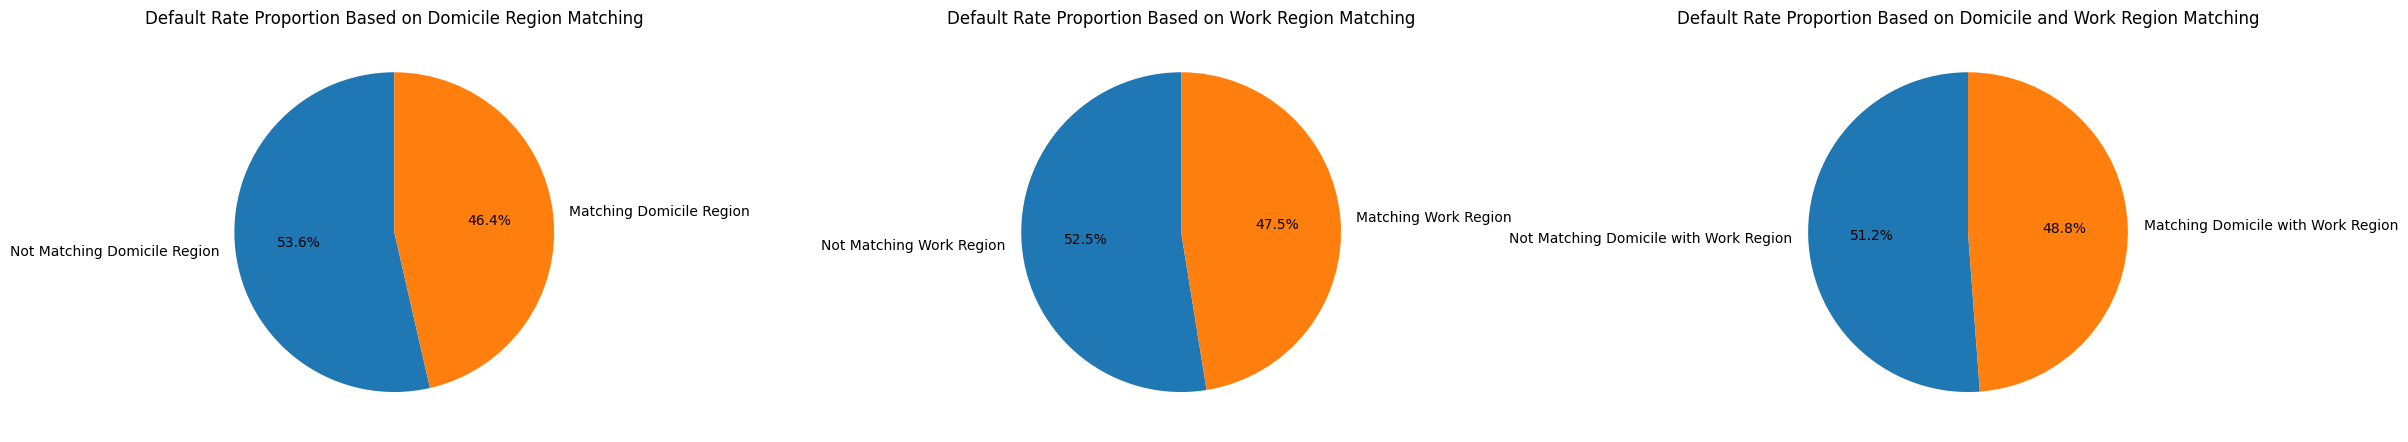

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Adjust figsize for desired dimensions
address_risk_live = df1.groupBy("REG_REGION_NOT_LIVE_REGION").agg(
    mean("TARGET").alias("default_rate"),
    count("*").alias("total_clients")
).orderBy("default_rate", ascending=False).toPandas()

address_risk_live["ADDRESS_COMBO"] = address_risk_live.apply(
    lambda row: f"{'Not Matching' if row['REG_REGION_NOT_LIVE_REGION'] == 1 else 'Matching'} Domicile Region",
    axis=1
)

axes[0].pie(address_risk_live["default_rate"], labels=address_risk_live["ADDRESS_COMBO"], autopct='%1.1f%%', startangle=90)
axes[0].set_title("Default Rate Proportion Based on Domicile Region Matching")
address_risk_work = df1.groupBy("REG_REGION_NOT_WORK_REGION").agg(
    mean("TARGET").alias("default_rate"),
    count("*").alias("total_clients")
).orderBy("default_rate", ascending=False).toPandas()

address_risk_work["ADDRESS_COMBO"] = address_risk_work.apply(
    lambda row: f"{'Not Matching' if row['REG_REGION_NOT_WORK_REGION'] == 1 else 'Matching'} Work Region",
    axis=1
)

axes[1].pie(address_risk_work["default_rate"], labels=address_risk_work["ADDRESS_COMBO"], autopct='%1.1f%%', startangle=90)
axes[1].set_title("Default Rate Proportion Based on Work Region Matching")

address_risk_live_work = df1.groupBy("LIVE_REGION_NOT_WORK_REGION").agg(
    mean("TARGET").alias("default_rate"),
    count("*").alias("total_clients")
).orderBy("default_rate", ascending=False).toPandas()

address_risk_live_work["ADDRESS_COMBO"] = address_risk_live_work.apply(
    lambda row: f"{'Not Matching' if row['LIVE_REGION_NOT_WORK_REGION'] == 1 else 'Matching'} Domicile with Work Region",
    axis=1
)

axes[2].pie(address_risk_live_work["default_rate"], labels=address_risk_live_work["ADDRESS_COMBO"], autopct='%1.1f%%', startangle=90)
axes[2].set_title("Default Rate Proportion Based on Domicile and Work Region Matching")
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
df1_0 = df1_cleaned.filter(col("TARGET") == 0)
df1_1 = df1_cleaned.filter(col("TARGET") == 1)

print("Jumlah data TARGET=0: %d" % df1_0.count())
print("Jumlah data TARGET=1: %d" % df1_1.count())

fraction = df1_1.count() / df1_0.count()
print("Fraction untuk undersampling: %.4f" % fraction)

df1_0_downsampled = df1_0.sample(withReplacement=False, fraction=fraction, seed=42)
df1_balanced = df1_0_downsampled.union(df1_1).orderBy(rand())
print("\nDistribusi TARGET setelah undersampling:")

df1_balanced.groupBy("TARGET").count().show()
train_df = df1_balanced.drop("SK_ID_CURR")
test_df = df2_cleaned.drop("SK_ID_CURR")

if "EMPLOYED_YEARS" in train_df.columns:
    train_df = train_df.drop("EMPLOYED_YEARS")
if "EMPLOYED_YEARS" in test_df.columns:
    test_df = test_df.drop("EMPLOYED_YEARS")

train_df = train_df.withColumn("label", col("TARGET")).drop("TARGET")
print("\nKolom-kolom pada training data:")
print(train_df.columns)
print("\nKolom-kolom pada test data:")
print(test_df.columns)


Jumlah data TARGET=0: 282686
Jumlah data TARGET=1: 24825
Fraction untuk undersampling: 0.0878

Distribusi TARGET setelah undersampling:
+------+-----+
|TARGET|count|
+------+-----+
|   0.0|24802|
|   1.0|24825|
+------+-----+


Kolom-kolom pada training data:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRC

In [ ]:
categorical_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE'
]

numeric_features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AGE_YEARS'
]

stages = []
for cat in categorical_features:
    indexer = StringIndexer(inputCol=cat, outputCol=cat + "_index", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[cat + "_index"], outputCols=[cat + "_ohe"])
    stages += [indexer, encoder]
numeric_assembler = VectorAssembler(inputCols=numeric_features, outputCol="numeric_assembled")
stages += [numeric_assembler]
scaler = StandardScaler(inputCol="numeric_assembled", outputCol="numeric_scaled", withMean=True, withStd=True)
stages += [scaler]
ohe_features = [cat + "_ohe" for cat in categorical_features]
assembler_inputs = ohe_features + ["numeric_scaled"]
final_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [final_assembler]

# Modeling

In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=123)
pipeline_rf = Pipeline(stages=stages + [rf])
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [50, 100])
                .addGrid(rf.maxDepth, [5, 6, 7])
                .build())

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
cv_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator, numFolds=5)
cvModel_rf = cv_rf.fit(train_df)
bestModel_rf = cvModel_rf.bestModel

print("\nBest Random Forest Model:")
print("  NumTrees:", bestModel_rf.stages[-1]._java_obj.getNumTrees())
print("  MaxDepth:", bestModel_rf.stages[-1]._java_obj.getMaxDepth())
train_predictions_rf = bestModel_rf.transform(train_df)
train_auc_rf = evaluator.evaluate(train_predictions_rf)
print("Training AUC: %.4f" % train_auc_rf)


Best Random Forest Model:
  NumTrees: 100
  MaxDepth: 7
Training AUC: 0.6840


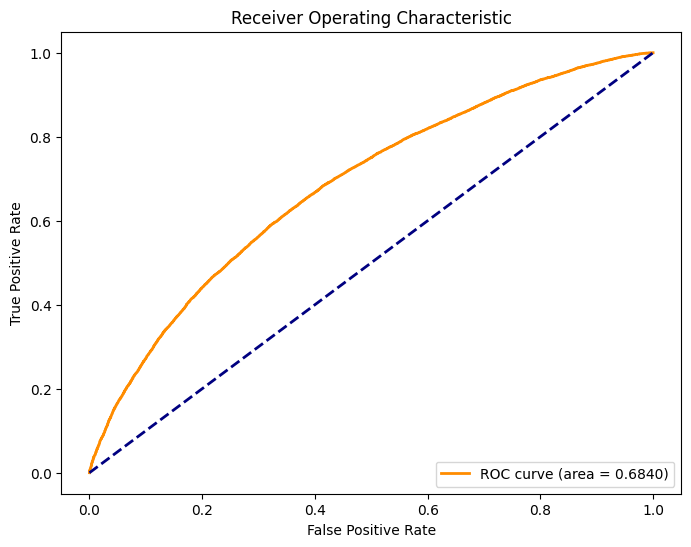

In [ ]:
train_predictions_rf = bestModel_rf.transform(train_df)
preds_pd = train_predictions_rf.select("label", "probability").toPandas()
preds_pd["probability_1"] = preds_pd["probability"].apply(lambda x: float(x[1]))
fpr, tpr, thresholds = roc_curve(preds_pd["label"], preds_pd["probability_1"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (area = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


In [ ]:
test_sample = df2_cleaned.limit(5)
predictions_sample = bestModel_rf.transform(test_sample)
predictions_sample.select("features", "prediction", "probability").show(truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |predictio